In [14]:
from math import factorial, exp
import matplotlib.pyplot as plt
import numpy as np
import csv
import time

def offeredTraffic(calls_per_hour, hours_per_call): # A0
    return calls_per_hour*hours_per_call

def erlangB(n, A0):
    denom = 0
    for i in range(n+1):
        denom += (A0**i)/(factorial(i))
    E1 = ((A0**n)/factorial(n))/denom
    return E1

def erlangC(n, A0):
    denomSum = 0
    for i in range(n):
        denomSum += (A0**i)/factorial(i)
    denom = A0**n + factorial(n)*(1-A0/n)*denomSum
    return (A0**n)/denom

def meanCallDelay(n, A0, meanCallDuration, probDelay):
    return probDelay*meanCallDuration/(n-A0)

def meanQueuedDelay(n, A0, meanCallDuration):
    return meanCallDuration/(n-A0)

def erlangC_allowedDelayGOS(n, A0, meanCallDuration, allowedDelay=0):
    probDelay = erlangC(n,A0)
    return probDelay*exp(-(n-A0)*allowedDelay/meanCallDuration)

In [15]:
def trafficSimulation(numChannels, numCalls, meanCallDuration, requeue=False, recheckChannelsDelay=0, allowedDelay=0, holdingDistrib='exp', repetitions=1, warmUpHours=None):

    callFailRates = np.zeros(repetitions)
    meanCallDelay = np.zeros(repetitions)

    for i in range(repetitions):
        time = 0
        channelFreeTimes = np.zeros(numChannels)
        
        if warmUpHours != None:
            # WARMUP SIMULATION
            # Get call durations
            if holdingDistrib == 'exp':
                callDurations = np.random.exponential(scale=meanCallDuration, size=int(numCalls*warmUpHours))

            elif holdingDistrib == 'gamma':
                callDurations = np.random.gamma(shape=1.2073, scale=0.03205, size=int(numCalls*warmUpHours)) # shape & scale by [4]: 0.03205 = muCHT*(mu/b) = muCHT*(29.6121/35.875)
            # Get call start times
            callStarts = np.random.uniform(size=int(numCalls*warmUpHours))
            callStarts.sort()
            calls = np.stack((callStarts, np.add(callStarts,callDurations)),axis=1) # Calls = Numpy array of [[call0_start call0_end]; [call1_start call1_end];...

            # Run warmup simulation
            
            callsFailed = 0
            totalDelay = 0
            for call in calls:
                time = call[0]
                channelFound = False

                for j in range(numChannels):
                    if not(channelFound):
                        if channelFreeTimes[j] <= time:
                            channelFreeTimes[j] = call[1]
                            channelFound = True

                if channelFound == False:
                    if requeue == False:
                        callsFailed += 1
                    elif recheckChannelsDelay > 0:
                        callsFailed += 1
                        while channelFound == False:
                            time += recheckChannelsDelay
                            totalDelay += recheckChannelsDelay
                            call[1] += recheckChannelsDelay # move forward call end time
                            for j in range(numChannels):
                                if not(channelFound): # Stop checking channels as soon as a free one is found
                                    if channelFreeTimes[j] <= time:
                                        channelFreeTimes[j] = call[1]
                                        channelFound = True
                            
                    else:
                        nextCallFinishTime = channelFreeTimes.min()
                        totalDelay += nextCallFinishTime-call[0]
                        call[1] += nextCallFinishTime-call[0]
                        if nextCallFinishTime-call[0]>allowedDelay: # only count call as failed if above the allowed wait time (if allowance present)
                            callsFailed += 1
                        indices = np.where(channelFreeTimes == nextCallFinishTime)
                        index = indices[0][0]
                        channelFreeTimes[index] = call[1]
                
        # MEASURED SIMULATION
        # Get call durations
        if holdingDistrib == 'exp':
            callDurations = np.random.exponential(scale=meanCallDuration, size=numCalls)

        elif holdingDistrib == 'gamma':
            callDurations = np.random.gamma(shape=1.2073, scale=0.03205, size=numCalls)

        # Get call start times
        callStarts = np.random.uniform(size=numCalls)
        callStarts.sort()
        calls = np.stack((callStarts, np.add(callStarts,callDurations)),axis=1)

        # Run measured simulation
        if warmUpHours != None:
            calls += warmUpHours 
            time = warmUpHours

        callsFailed = 0
        totalDelay = 0
        for call in calls:
            time = call[0]
            channelFound = False

            for j in range(numChannels):
                if not(channelFound):
                    if channelFreeTimes[j] <= time:
                        channelFreeTimes[j] = call[1]
                        channelFound = True

            if channelFound == False:
                if requeue == False:
                    callsFailed += 1

                elif recheckChannelsDelay > 0:
                    callsFailed += 1
                    while channelFound == False:
                        time += recheckChannelsDelay
                        totalDelay += recheckChannelsDelay

                        call[1] += recheckChannelsDelay # move forward call end time
                        for j in range(numChannels):
                            if not(channelFound): # Stop checking channels as soon as a free one is found
                                if channelFreeTimes[j] <= time:
                                    channelFreeTimes[j] = call[1]
                                    channelFound = True
                        
                else:
                    nextCallFinishTime = channelFreeTimes.min()
                    totalDelay += nextCallFinishTime-call[0]
                    call[1] += nextCallFinishTime-call[0]
                    if nextCallFinishTime-call[0]>allowedDelay: # only count call as failed if above the allowed wait time (if allowance present)
                        callsFailed += 1
                    indices = np.where(channelFreeTimes == nextCallFinishTime)
                    index = indices[0][0]
                    channelFreeTimes[index] = call[1]

        callFailRates[i] = callsFailed/numCalls
        meanCallDelay[i] = totalDelay/numCalls

    if requeue == False:
        return callFailRates.mean(), np.std(callFailRates, ddof=1)
    else:
        return callFailRates.mean(), np.std(callFailRates, ddof=1), meanCallDelay.mean(), np.std(meanCallDelay, ddof=1)

In [16]:
meanCallDuration = 2.33/60 # 2.33 mins in hrs
n = 57 # number of channels

# Calls:	Traffic:	Erlang B:		Sim GOS (exp):		stdDev (exp):
25		0.9708		0.0000			0.0000			0.0000
161		6.2522		0.0000			0.0000			0.0000
297		11.5335		0.0000			0.0000			0.0000
434		16.8537		0.0000			0.0000			0.0000
570		22.1350		0.0000			0.0000			0.0000
706		27.4163		0.0000			0.0000			0.0000
842		32.6977		0.0033			0.0000			0.0000
978		37.9790		0.0857			0.0368			0.1360
1114		43.2603		0.7410			0.5081			0.5395
1250		48.5417		2.9239			2.4472			1.0976
1386		53.8230		6.8968			5.9820			1.3837
1522		59.1043		11.9388			11.0329			1.6611
1659		64.4245		17.2882			16.3213			1.5786
1795		69.7058		22.4059			21.5164			1.8261
1931		74.9872		27.1444			25.7929			1.6562


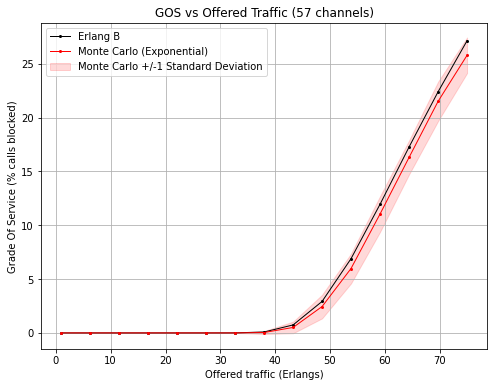

10.992500066757202


In [17]:
# CALLS BLOCKED - NO REQUEUING
startTime = time.time()

simulationCallAmounts = (np.linspace(1, 75, 15)/meanCallDuration).astype(np.int)
A0s = offeredTraffic(simulationCallAmounts, meanCallDuration)
repetitionsPerSimulation = 100

# Initialise arrays for results
erlangBs = np.zeros(simulationCallAmounts.shape)
GOS_exp = np.zeros(simulationCallAmounts.shape)
stdDevs_exp = np.zeros(simulationCallAmounts.shape)
# GOS_gamma = np.zeros(simulationCallAmounts.shape)
# stdDevs_gamma = np.zeros(simulationCallAmounts.shape)

# Run simulations
print("# Calls:\tTraffic:\tErlang B:\t\tSim GOS (exp):\t\tstdDev (exp):")
for i, numCalls in enumerate(simulationCallAmounts):
    A0 = A0s[i]
    erlangBs[i] = erlangB(n, A0)*100

    meanBlockingRate_exp, stdDev_exp = trafficSimulation(n, numCalls, meanCallDuration, repetitions=repetitionsPerSimulation)
    GOS_exp[i] = meanBlockingRate_exp*100
    stdDevs_exp[i] = stdDev_exp*100

#     meanBlockingRate_gamma, stdDev_gamma = trafficSimulation(n, numCalls, meanCallDuration, holdingDistrib='gamma', repetitions=repetitionsPerSimulation)
#     GOS_gamma[i] = meanBlockingRate_gamma*100
#     stdDevs_gamma[i] = stdDev_gamma*100
    print("{}\t\t{:.4f}\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}".format(numCalls, A0, erlangBs[i], GOS_exp[i], stdDevs_exp[i]))

# PLOT
plt.figure(figsize=(8,6))
markerSize=2
lineWidth=1
plt.plot(A0s, erlangBs, label='Erlang B', color="black", marker='o', markersize=markerSize, linewidth=lineWidth)
plt.plot(A0s, GOS_exp, label="Monte Carlo (Exponential)", color="red", marker='o', markersize=markerSize, linewidth=lineWidth)
plt.fill_between(A0s, GOS_exp+stdDevs_exp, GOS_exp-stdDevs_exp, interpolate=True, color="red", alpha=0.15, label="Monte Carlo +/-1 Standard Deviation")
# plt.plot(A0s, GOS_gamma, label="Monte Carlo (Gamma)", color="green", marker='o', markersize=markerSize, linewidth=lineWidth)
# plt.fill_between(A0s, GOS_gamma+stdDevs_gamma, GOS_gamma-stdDevs_gamma, interpolate=True, color="green", alpha=0.15)

plt.xlabel('Offered traffic (Erlangs)')
plt.ylabel('Grade Of Service (% calls blocked)')
plt.title("GOS vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.grid()
plt.savefig("sim1_1.png")
plt.show()

timeTaken = time.time()-startTime
print(timeTaken)

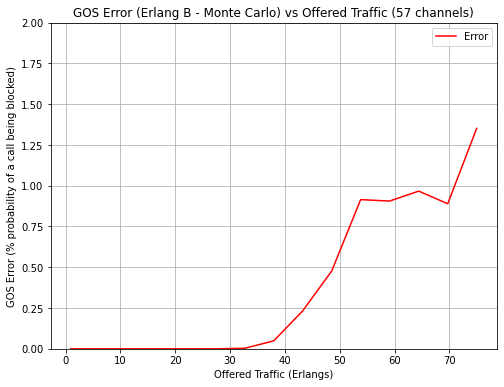

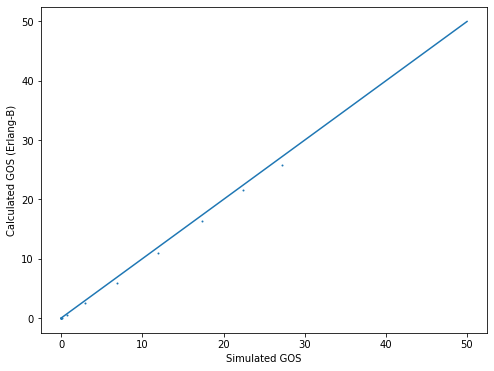

In [18]:
# ERROR
error = erlangBs-GOS_exp

plt.figure(figsize=(8,6))
plt.plot(A0s, error, label="Error", color='red')
# plt.vlines(x = A0s[n//2], ymin = 0, ymax = error[n//2], color = 'blue', label = 'Offered Traffic = 57 = # channels', linewidth=1)

plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('GOS Error (% probability of a call being blocked)')
plt.title("GOS Error (Erlang B - Monte Carlo) vs Offered Traffic ({} channels)".format(n))
plt.ylim([0,2])
plt.legend()
plt.grid()
plt.savefig('sim1_2.png')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(erlangBs, GOS_exp, 1, vmin=0, vmax=1)
plt.xlabel('Simulated GOS')
plt.ylabel('Calculated GOS (Erlang-B)')
plt.plot([0,50],[0,50])
plt.show()

In [19]:
# Save to csv
with open('block.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["# Calls", "Offered Traffic", "Erlang B:", "Sim GOS (exponential):", "Sim std dev (exponential):", "Repetitions per simulation = "+str(repetitionsPerSimulation)])
    # (numCalls, A0, erlangBs[i], GOS_exp[i], stdDevs_exp[i],
    for i, numCalls in enumerate(simulationCallAmounts):
        writer.writerow([numCalls, A0s[i], erlangBs[i], GOS_exp[i], stdDevs_exp[i]])

# Calls:	Traffic:	Erlang C:		Sim GOS (exp):		Sim GOS stdDev		Calc. delay/call	Sim Mean delay/call	delay/call stdDev
25		0.9708			0.000			0.000			0.0000			0.0000			0.0000			0.0000
51		1.9805			0.000			0.000			0.0000			0.0000			0.0000			0.0000
77		2.9902			0.000			0.000			0.0000			0.0000			0.0000			0.0000
103		3.9998			0.000			0.000			0.0000			0.0000			0.0000			0.0000
128		4.9707			0.000			0.000			0.0000			0.0000			0.0000			0.0000
154		5.9803			0.000			0.000			0.0000			0.0000			0.0000			0.0000
180		6.9900			0.000			0.000			0.0000			0.0000			0.0000			0.0000
206		7.9997			0.000			0.000			0.0000			0.0000			0.0000			0.0000
231		8.9705			0.000			0.000			0.0000			0.0000			0.0000			0.0000
257		9.9802			0.000			0.000			0.0000			0.0000			0.0000			0.0000
283		10.9898			0.000			0.000			0.0000			0.0000			0.0000			0.0000
309		11.9995			0.000			0.000			0.0000			0.0000			0.0000			0.0000
334		12.9703			0.000			0.000			0.0000			0.0000			0.0000			0.0000
360		13.9800			0.000			0.000			0.0000			0.0000			0.0

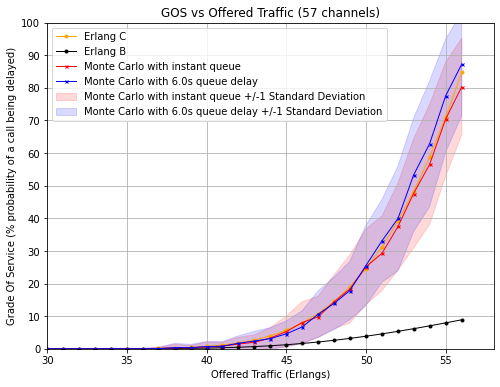

193.5094997882843


In [20]:
# WITH REQUEUING
startTime = time.time()

simulationCallAmounts = (np.linspace(1, n-1, n-1)/meanCallDuration).astype(np.int)
A0s = offeredTraffic(simulationCallAmounts, meanCallDuration)
repetitionsPerSimulation = 100

# Initialise arrays for results
erlangBs = np.zeros(simulationCallAmounts.shape)
erlangCs = np.zeros(simulationCallAmounts.shape)
meanCallDelays_calc = np.zeros(simulationCallAmounts.shape)

qGOS_exp = np.zeros(simulationCallAmounts.shape)
qStdDevs_exp = np.zeros(simulationCallAmounts.shape)
meanCallDelays_exp = np.zeros(simulationCallAmounts.shape)
callDelayStdDevs_exp = np.zeros(simulationCallAmounts.shape)

qGOS_exp_delayed = np.zeros(simulationCallAmounts.shape)
qStdDevs_exp_delayed = np.zeros(simulationCallAmounts.shape)
meanCallDelays_exp_delayed = np.zeros(simulationCallAmounts.shape)
callDelayStdDevs_exp_delayed = np.zeros(simulationCallAmounts.shape)

# GOS_gamma = np.zeros(simulationCallAmounts.shape)
# stdDevs_gamma = np.zeros(simulationCallAmounts.shape)
# meanCallDelays_gamma = np.zeros(simulationCallAmounts.shape)
# callDelayStdDevs_gamma = np.zeros(simulationCallAmounts.shape)

allowedDelay = 0 # (in hours)
recheckDelay = 0.1/60 # (in hours)

# Run simulations
print("# Calls:\tTraffic:\tErlang C:\t\tSim GOS (exp):\t\tSim GOS stdDev\t\tCalc. delay/call\tSim Mean delay/call\tdelay/call stdDev")
for i, numCalls in enumerate(simulationCallAmounts):

    A0 = A0s[i]
    erlangBs[i] = erlangB(n, A0)*100
    erlangCs[i] = erlangC_allowedDelayGOS(n, A0, meanCallDuration, allowedDelay=allowedDelay)*100
    meanCallDelays_calc[i] = meanCallDelay(n, A0, meanCallDuration, np.clip(erlangCs/100,0,1)[i])

    meanDelayRate_exp, stdDev_exp,  meanCallDelay_exp, callDelayStdDev_exp = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, recheckChannelsDelay=0, repetitions=repetitionsPerSimulation, warmUpHours=1)
    qGOS_exp[i] = meanDelayRate_exp*100
    qStdDevs_exp[i] = stdDev_exp*100
    meanCallDelays_exp[i] = meanCallDelay_exp
    callDelayStdDevs_exp[i] = callDelayStdDev_exp
    
    meanDelayRate_exp_delayed, stdDev_exp_delayed,  meanCallDelay_exp_delayed, callDelayStdDev_exp_delayed = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, recheckChannelsDelay=recheckDelay, repetitions=repetitionsPerSimulation, warmUpHours=1)
    qGOS_exp_delayed[i] = meanDelayRate_exp_delayed*100
    qStdDevs_exp_delayed[i] = stdDev_exp_delayed*100
    meanCallDelays_exp_delayed[i] = meanCallDelay_exp_delayed
    callDelayStdDevs_exp_delayed[i] = callDelayStdDev_exp_delayed

    # meanDelayRate_gamma, stdDev_gamma,  meanCallDelay_gamma, callDelayStdDev_gamma = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, holdingDistrib='gamma recheckChannelsDelay=0, repetitions=repetitionsPerSimulation, warmUpHours=1)
    # GOS_gamma[i] = meanDelayRate_gamma*100
    # stdDevs_gamma[i] = stdDev_gamma*100
    # meanCallDelays_gamma[i] = meanCallDelay_gamma
    # callDelayStdDevs_gamma[i] = callDelayStdDev_gamma

    print("{}\t\t{:.4f}\t\t\t{:.3f}\t\t\t{:.3f}\t\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}".format(numCalls, A0, erlangCs[i], qGOS_exp[i], qStdDevs_exp[i], meanCallDelays_calc[i], meanCallDelays_exp[i], callDelayStdDevs_exp[i]))

# PLOT RESULTS
plt.figure(figsize=(8,6))
markerSize = 3
lineWidth = 1
plt.plot(A0s, erlangCs, label='Erlang C', color="orange", marker='o', markersize=markerSize, linewidth=lineWidth)
plt.plot(A0s, erlangBs, label='Erlang B', color="black", marker='o', markersize=markerSize, linewidth=lineWidth)
plt.plot(A0s, qGOS_exp, label="Monte Carlo with instant queue", color="red", marker='x', markersize=markerSize, linewidth=lineWidth)
plt.fill_between(A0s, qGOS_exp+qStdDevs_exp,  qGOS_exp-qStdDevs_exp, interpolate=True, color="red", alpha=0.15, label="Monte Carlo with instant queue +/-1 Standard Deviation")
# plt.errorbar(A0s, qGOS_exp, yerr=qStdDevs_exp, label="Monte Carlo with requeue (Exponential)", color="red")
plt.plot(A0s, qGOS_exp_delayed, label="Monte Carlo with {}s queue delay".format(recheckDelay*3600), color="blue", marker='x', markersize=markerSize, linewidth=lineWidth)
plt.fill_between(A0s, qGOS_exp_delayed+qStdDevs_exp_delayed,  qGOS_exp_delayed-qStdDevs_exp_delayed, interpolate=True, color="blue", alpha=0.15, label="Monte Carlo with {}s queue delay +/-1 Standard Deviation".format(recheckDelay*3600))
# plt.errorbar(A0s, GOS_gamma, yerr=stdDevs_gamma, label="Monte Carlo with requeue (Gamma)", color="green")
# plt.fill_between(A0s, GOS_gamma+stdDevs_gamma, GOS_gamma-stdDevs_gamma, interpolate=True, color="green", alpha=0.15)
# plt.vlines(x = n, ymin = 0, ymax = 100, color = 'blue', label = 'Offered Traffic = n channels')
plt.xlim([30,58])
plt.ylim([0,100])
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('Grade Of Service (% probability of a call being delayed)')
# plt.ylabel('Grade Of Service (% probability of a call being delayed for > {} sec)'.format(allowedDelay*3600))
plt.title("GOS vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.savefig("sim2_1.png")
plt.yticks(np.linspace(0,100,11))
plt.grid()
plt.show()

timeTaken = time.time()-startTime
print(timeTaken)

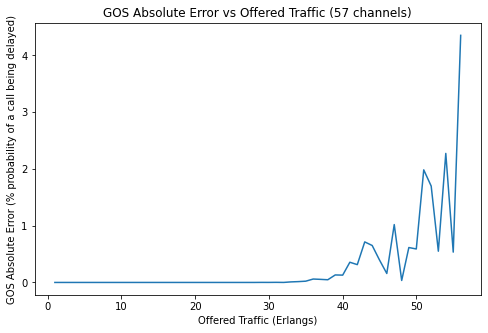

0.29847046179561953


In [21]:
# ERROR
qError = erlangCs-qGOS_exp
qAbsError = np.abs(qError)
plt.figure(figsize=(8,5))
plt.plot(A0s, qAbsError)
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('GOS Absolute Error (% probability of a call being delayed)')
plt.title("GOS Absolute Error vs Offered Traffic ({} channels)".format(n))
plt.show()
print(qAbsError.mean())

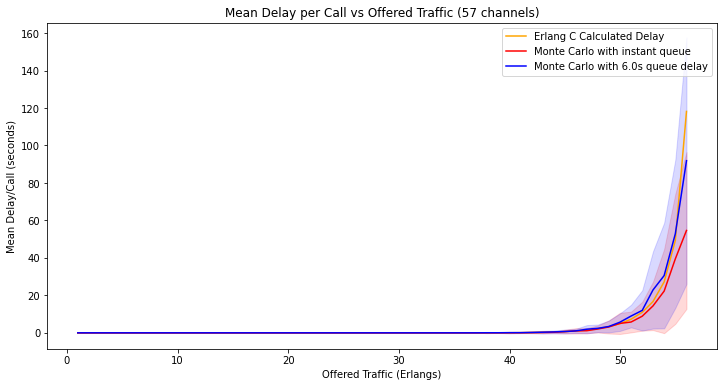

In [22]:
# DELAY DURATION PLOTS
plt.figure(figsize=(12,6))
plt.plot(A0s, meanCallDelays_calc*3600, label='Erlang C Calculated Delay', color="orange")
plt.plot(A0s, meanCallDelays_exp*3600, label="Monte Carlo with instant queue", color="red")
plt.fill_between(A0s, meanCallDelays_exp*3600+callDelayStdDevs_exp*3600, meanCallDelays_exp*3600-callDelayStdDevs_exp*3600, interpolate=True, color="red", alpha=0.15)
plt.plot(A0s, meanCallDelays_exp_delayed*3600, label="Monte Carlo with {}s queue delay".format(recheckDelay*3600), color="blue")
plt.fill_between(A0s, meanCallDelays_exp_delayed*3600+callDelayStdDevs_exp_delayed*3600, meanCallDelays_exp_delayed*3600-callDelayStdDevs_exp_delayed*3600, interpolate=True, color="blue", alpha=0.15)
# plt.xlim([30,60])
plt.xlabel('Offered Traffic (Erlangs)')
plt.ylabel('Mean Delay/Call (seconds)')
plt.title("Mean Delay per Call vs Offered Traffic ({} channels)".format(n))
plt.legend()
plt.show()